In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

In [2]:
train0 = pd.read_pickle('D:\\CS760\\pj\\train_set_0.pkl')
train1 = pd.read_pickle('D:\\CS760\\pj\\train_set_1.pkl')
train2 = pd.read_pickle('D:\\CS760\\pj\\train_set_2.pkl')
train_set = pd.concat([train0,train1], ignore_index=True)
training = pd.concat([train_set,train2], ignore_index=True)

In [3]:
testset = pd.read_pickle('D:\\CS760\\pj\\test_set.pkl')

In [4]:
testset

,channelGrouping,fullVisitorId,visitStartTime,device_browser,device_operatingSystem,geoNetwork_country,totals_hits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_transactionRevenue,totals_transactions,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_isTrueDirect
0,Organic Search,7460955084541987166,1526099341,Chrome,Android,India,4,3,1,973,0.0,0,True,0,True
1,Direct,460252456180441002,1526064483,Chrome,Macintosh,United States,4,3,1,49,0.0,0,True,0,True
2,Organic Search,3461808543879602873,1526067157,Chrome,Chrome OS,United States,4,3,1,24,0.0,0,True,0,True
3,Direct,975129477712150630,1526107551,Chrome,iOS,United States,5,4,1,25,0.0,0,True,0,True
4,Organic Search,8381672768065729990,1526060254,Internet Explorer,Windows,United States,5,4,1,49,0.0,0,True,0,False
5,Organic Search,2866297766347322467,1526061951,Chrome,Windows,Brazil,5,4,1,120,0.0,0,True,0,True
6,Direct,2235365487897339889,1526062356,Chrome,Android,United States,5,4,1,58,0.0,0,True,0,True
7,Organic Search,1303090465617023038,1526078660,Chrome,Macintosh,United States,5,4,1,56,0.0,0,True,0,True
8,Affiliates,0459669224143241747,1526054953,Safari (in-app),iOS,Taiwan,5,3,1,57,0.0,0,True,0,False
9,Direct,589440789980446309,1526051458,Edge,Windows,Spain,5,3,1,22,0.0,0,True,0,True


In [5]:
device = ['Chrome','Firefox','Opera','Safari','Edge','Android Browser','Seznam','Samsung Internet','Internet Explorer',
          'UC Browser','YaBrowser','Amazon Silk','BlackBerry','Coc Coc','Mozilla','Maxthon', 'Nintendo Browser',
         'Playstation Vita Browser', 'Nokia Browser','MRCHROME','SeaMonkey','Puffin']
training['device_browser'].replace({'Opera Mini':'Opera', 'Safari (in-app)':'Safari', 'Android Webview':'Android Browser',
                                   'Mozilla Compatible Agent':'Mozilla'}, inplace=True)
training.loc[~training['device_browser'].isin(device),'device_browser']='others'

In [6]:
trainset = training.sample(frac=3/4,random_state=101)
validset = training.loc[~training.index.isin(trainset.index), :]

In [7]:
class ThreeLayerNet(nn.Module):

    def __init__(self, D_in, H1, H2, drop):
        super(ThreeLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, 1)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        hidden_layer1 = self.drop(F.softmax(self.linear1(x.float())) )
        
        hidden_layer2 = self.drop(F.softmax(self.linear2(hidden_layer1)))
        y_pred = self.linear3(hidden_layer2)
        return y_pred

In [8]:
def train(model, x, y,criterion,optimizer):
    """
   train NN
    """
    model.train()
    y_pred = model(x)
    loss = criterion(y_pred.float(), y.float())
    print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [9]:
def valid(model, x_valid, y_valid,criterion):
    """
    test NN
    """
    model.eval()
    y_pred = model(x_valid)
    loss = criterion(y_pred.float(), y_valid.float())
    #print(loss.item())
    return loss.item()

In [10]:
def ordinal(data):
    categorical = ['channelGrouping','device_browser','device_operatingSystem','geoNetwork_country']
    boolean = ['trafficSource_adwordsClickInfo.isVideoAd','trafficSource_isTrueDirect']
    for col in categorical:
        attributes = data[col].unique()
        d = dict(enumerate(attributes,start=1))
        new = dict((v,k) for k,v in d.items())
        data[col].replace(new,inplace = True)
    for col in boolean:
        data[col].replace({True:1,False:0},inplace=True)
    return data

In [11]:
def standardize(TrainSet,TestSet):
    standard=np.array(TrainSet)
    standard_test=np.array(TestSet)
    mean_array=np.mean(standard,axis=0)
    stdev=np.std(standard,axis=0,ddof=1)
    if stdev==0:
        stdev=1
    outcome = (standard_test - mean_array) / stdev
    return outcome

In [12]:
def standard(data):
    numerical = ['totals_hits','totals_pageviews','totals_sessionQualityDim','totals_timeOnSite',
                 'totals_transactionRevenue','totals_transactions']
    for col in numerical:
        data[col]=standardize(data[col],data[col])
    return data

In [13]:
def GetData(A, B):
    dataset1 = A.copy()
    dataset2 = B.copy()
    
    ID = dataset1[['fullVisitorId']]
    # y = log(1+revenue)
    dataset1['totals_transactionRevenue'] = np.log(dataset1['totals_transactionRevenue']+1)
    dataset2['totals_transactionRevenue'] = np.log(dataset2['totals_transactionRevenue']+1)
    
    # ordinal encoding categorical features  
    dataset1 = ordinal(dataset1)
    
    # standardize numerical features
    numerical = ['totals_hits','totals_pageviews','totals_sessionQualityDim','totals_timeOnSite',
                 'totals_transactionRevenue','totals_transactions']
    for col in numerical:
        #standardize dataset1 based on dataset2
        dataset1[col]=standardize(dataset2[col],dataset1[col]) 
    # load y
    train_y = dataset1[['totals_transactionRevenue']]
    
    y = torch.tensor(train_y.values)
    # load x
    train_x = dataset1.drop(['totals_transactionRevenue','fullVisitorId','visitStartTime'], axis=1)
    x = torch.tensor(train_x.to_numpy(dtype=np.float))   
    return x,y,ID

In [14]:
train_x, train_y, train_ID = GetData(trainset,trainset)
valid_x, valid_y, valid_ID = GetData(validset,trainset)

In [15]:
test_x, test_y, test_ID = GetData(testset,trainset)

In [16]:
model1 = ThreeLayerNet(train_x.shape[1], 8 , 8, 0.5)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train=[]
for i in range(100):
    print(i,' ', end='')
    loss_train.append(train(model1,train_x,train_y,criterion,optimizer))
    
model1_loss = valid(model1, valid_x, valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


1.0137112140655518
1  1.017813801765442
2  0.9988725185394287
3  0.9974212050437927
4  0.9980931282043457
5  0.9913975596427917
6  0.9877350926399231
7  0.9866930842399597
8  0.9816438555717468
9  0.9728444814682007
10  0.9660313129425049
11  0.9579681158065796
12  0.9508059620857239
13  0.9415972828865051
14  0.9351693391799927
15  0.9252590537071228
16  0.917048454284668
17  0.9053147435188293
18  0.8970714211463928
19  0.8860258460044861
20  0.8773550391197205
21  0.8689326643943787
22  0.8575418591499329
23  0.8552550673484802
24  0.8439486622810364
25  0.8404141068458557
26  0.8263365030288696
27  0.8216270804405212
28  0.8117855787277222
29  0.8114526271820068
30  0.8036662340164185
31  0.7982987761497498
32  0.7965863347053528
33  0.7865155339241028
34  0.7874952554702759
35  0.7840177416801453
36  0.7761422395706177
37  0.7763714790344238
38  0.7732825875282288
39  0.7689446806907654
40  0.7624002695083618
41  0.7664457559585571
42  0.7587577104568481
43  0.7529884576797485
44 

In [17]:
model2 = ThreeLayerNet(train_x.shape[1], 4 , 4, 0.5)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train2=[]

for i in range(100):
    print(i,' ', end='')
    loss_train2.append(train(model2,train_x,train_y,criterion,optimizer))

model2_loss = valid(model2, valid_x, valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


1.0948799848556519
1  1.0619689226150513
2  1.0599156618118286
3  1.0392613410949707
4  1.0206129550933838
5  1.011301875114441
6  1.0086169242858887
7  1.0083409547805786
8  1.0069053173065186
9  1.0048829317092896
10  1.0038690567016602
11  1.003835678100586
12  1.003600835800171
13  1.0031063556671143
14  1.0027709007263184
15  1.0033754110336304
16  1.0046225786209106
17  1.0043907165527344
18  1.0041158199310303
19  1.0035508871078491
20  1.003669023513794
21  1.0034009218215942
22  1.0026476383209229
23  1.001936912536621
24  1.0014479160308838
25  1.0016430616378784
26  1.0015928745269775
27  1.001491904258728
28  1.001491665840149
29  1.00161612033844
30  1.001604437828064
31  1.0012282133102417
32  1.0009384155273438
33  1.0009170770645142
34  1.000834345817566
35  1.0006901025772095
36  1.0005611181259155
37  1.0005934238433838
38  1.0006412267684937
39  1.0006037950515747
40  1.0004338026046753
41  1.0004171133041382
42  1.0004136562347412
43  1.000242829322815
44  1.0001822

In [18]:
model3 = ThreeLayerNet(train_x.shape[1], 16 , 16, 0.5)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train3=[]

for i in range(100):
    print(i,' ', end='')
    loss_train3.append(train(model3,train_x,train_y,criterion,optimizer))

model3_loss = valid(model3, valid_x, valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


1.0606811046600342
1  1.0011008977890015
2  1.0172120332717896
3  1.0243549346923828
4  1.0099822282791138
5  1.0019643306732178
6  1.0044363737106323
7  1.0093671083450317
8  1.009227991104126
9  1.004982590675354
10  1.0012775659561157
11  1.0010908842086792
12  1.0037500858306885
13  1.0051524639129639
14  1.0045270919799805
15  1.0020323991775513
16  1.000822901725769
17  1.001333475112915
18  1.0024373531341553
19  1.0024837255477905
20  1.0013129711151123
21  1.0004469156265259
22  1.0006064176559448
23  1.0013315677642822
24  1.0015196800231934
25  1.000984787940979
26  1.0003173351287842
27  1.0002468824386597
28  1.0005778074264526
29  1.000846266746521
30  1.0006473064422607
31  1.0002448558807373
32  1.0001299381256104
33  1.000296950340271
34  1.0005066394805908
35  1.0004888772964478
36  1.0002363920211792
37  1.0000686645507812
38  1.0001304149627686
39  1.0002915859222412
40  1.0002866983413696
41  1.0001378059387207
42  1.0000371932983398
43  1.0000758171081543
44  1.00

In [19]:
model4 = ThreeLayerNet(train_x.shape[1], 32, 32, 0.5)
optimizer = torch.optim.Adam(model4.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train4=[]

for i in range(100):
    print(i,' ', end='')
    loss_train4.append(train(model4,train_x,train_y,criterion,optimizer))

model4_loss = valid(model4, valid_x, valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


1.0052506923675537
1  1.014994502067566
2  0.9961766004562378
3  0.9923891425132751
4  0.9945084452629089
5  0.9850122332572937
6  0.9735084176063538
7  0.9650015830993652
8  0.9561704397201538
9  0.9423840045928955
10  0.9333001375198364
11  0.9120386242866516
12  0.9020532369613647
13  0.8893870711326599
14  0.8680903315544128
15  0.8578406572341919
16  0.8412666320800781
17  0.8290308713912964
18  0.8210449814796448
19  0.7948017120361328
20  0.77720707654953
21  0.7509421110153198
22  0.7474340796470642
23  0.7207218408584595
24  0.7069304585456848
25  0.6834889650344849
26  0.6683112978935242
27  0.6615803241729736
28  0.6384002566337585
29  0.6078160405158997
30  0.6154775619506836
31  0.6030918955802917
32  0.5759274363517761
33  0.5899034738540649
34  0.551395833492279
35  0.5399572849273682
36  0.5307292342185974
37  0.5166632533073425
38  0.49556711316108704
39  0.48342156410217285
40  0.4650622606277466
41  0.46426934003829956
42  0.4569784700870514
43  0.430001825094223
44 

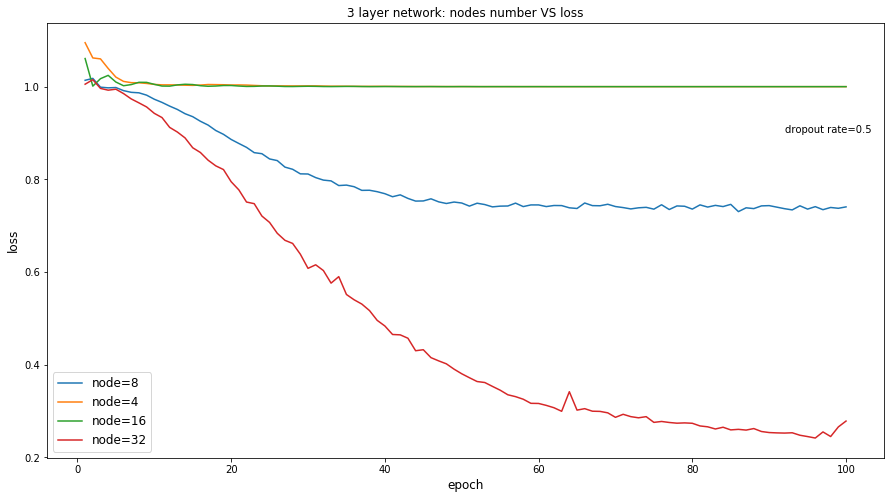

In [20]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(range(1,101),loss_train,label = 'node=8')
ax.plot(range(1,101),loss_train2,label = 'node=4')
ax.plot(range(1,101),loss_train3,label = 'node=16')
ax.plot(range(1,101),loss_train4,label = 'node=32')
ax.set_xlabel('epoch',fontsize='large')
ax.set_ylabel('loss',fontsize='large')
ax.legend(fontsize='large')
ax.set_title('3 layer network: nodes number VS loss')
ax.text(92,0.9,'dropout rate=0.5')
fig.savefig('D:\\CS760\\pj\\3layer_1.jpg')

In [21]:
class ThreeLayerNet2(nn.Module):

    def __init__(self, D_in, H1, H2):
        super(ThreeLayerNet2, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, 1)
    
    def forward(self, x):
        hidden_layer1 = F.softmax(self.linear1(x.float())) 
        hidden_layer2 = F.softmax(self.linear2(hidden_layer1))
        y_pred = self.linear3(hidden_layer2)
        return y_pred

In [22]:
model5 = ThreeLayerNet(train_x.shape[1], 8, 8, 0.2)
optimizer = torch.optim.Adam(model5.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train5=[]

for i in range(100):
    print(i,' ', end='')
    loss_train5.append(train(model5,train_x,train_y,criterion,optimizer))
    
model5_loss = valid(model5, valid_x, valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


1.017287015914917
1  1.0045201778411865
2  1.0025629997253418
3  0.9868028163909912
4  0.9818795919418335
5  0.9791803359985352
6  0.9683824777603149
7  0.9532361626625061
8  0.9416114091873169
9  0.9343876838684082
10  0.9199185967445374
11  0.9009476900100708
12  0.884309709072113
13  0.8774433135986328
14  0.8595216274261475
15  0.8436300754547119
16  0.8261062502861023
17  0.8044230937957764
18  0.7899074554443359
19  0.7620102167129517
20  0.7460594177246094
21  0.7234976887702942
22  0.7160106897354126
23  0.7009705305099487
24  0.6734351515769958
25  0.6628429889678955
26  0.6508266925811768
27  0.6390308141708374
28  0.6208189129829407
29  0.6100010275840759
30  0.5935705900192261
31  0.5854209065437317
32  0.5733446478843689
33  0.5562687516212463
34  0.5504793524742126
35  0.5393239855766296
36  0.5232534408569336
37  0.5187550783157349
38  0.5069152116775513
39  0.5006308555603027
40  0.49079716205596924
41  0.48393574357032776
42  0.4682583808898926
43  0.4632927179336548
4

In [23]:
model6 = ThreeLayerNet(train_x.shape[1], 8, 8, 0.4)
optimizer = torch.optim.Adam(model6.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train6=[]

for i in range(100):
    print(i,' ', end='')
    loss_train6.append(train(model6,train_x,train_y,criterion,optimizer))
    
model6_loss = valid(model6, valid_x, valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


1.0189608335494995
1  1.0069777965545654
2  1.0121229887008667
3  1.0003526210784912
4  0.9971943497657776
5  1.0000110864639282
6  0.9960911273956299
7  0.9871722459793091
8  0.9800132513046265
9  0.9759839773178101
10  0.969254195690155
11  0.9572374820709229
12  0.9431319832801819
13  0.9301946759223938
14  0.9215510487556458
15  0.9092000126838684
16  0.8974619507789612
17  0.8756285905838013
18  0.8691245317459106
19  0.8516003489494324
20  0.8399389982223511
21  0.8261650800704956
22  0.8114424347877502
23  0.8059507608413696
24  0.7910618782043457
25  0.7901985049247742
26  0.7741357684135437
27  0.7646507024765015
28  0.7576720118522644
29  0.7426453828811646
30  0.7379708886146545
31  0.732775866985321
32  0.7223987579345703
33  0.7176344990730286
34  0.71211838722229
35  0.7039936184883118
36  0.6964970827102661
37  0.6941730380058289
38  0.6849681735038757
39  0.6830718517303467
40  0.669249951839447
41  0.6669398546218872
42  0.6670083403587341
43  0.6516845226287842
44  0.

In [24]:
model7 = ThreeLayerNet2(train_x.shape[1], 8, 8)
optimizer = torch.optim.Adam(model7.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train7=[]

for i in range(100):
    print(i,' ', end='')
    loss_train7.append(train(model7,train_x,train_y,criterion,optimizer))
    
model7_loss = valid(model7, valid_x, valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


1.0020118951797485
1  1.0131529569625854
2  0.978255569934845
3  0.9744514226913452
4  0.9667444825172424
5  0.9448366165161133
6  0.9235951900482178
7  0.9059056043624878
8  0.8836652636528015
9  0.8545240163803101
10  0.8231174945831299
11  0.793281078338623
12  0.764621376991272
13  0.7332882881164551
14  0.700126588344574
15  0.6692741513252258
16  0.6411484479904175
17  0.611955463886261
18  0.5816510915756226
19  0.5533129572868347
20  0.5274172425270081
21  0.5008116960525513
22  0.4738673269748688
23  0.4487397372722626
24  0.42487385869026184
25  0.40080100297927856
26  0.3771843910217285
27  0.35509222745895386
28  0.3340986967086792
29  0.3131279945373535
30  0.29321879148483276
31  0.2742949426174164
32  0.2562989592552185
33  0.23884272575378418
34  0.22219878435134888
35  0.20654179155826569
36  0.19174374639987946
37  0.17751245200634003
38  0.16409730911254883
39  0.1516079604625702
40  0.13976947963237762
41  0.12852314114570618
42  0.11807824671268463
43  0.1083691343

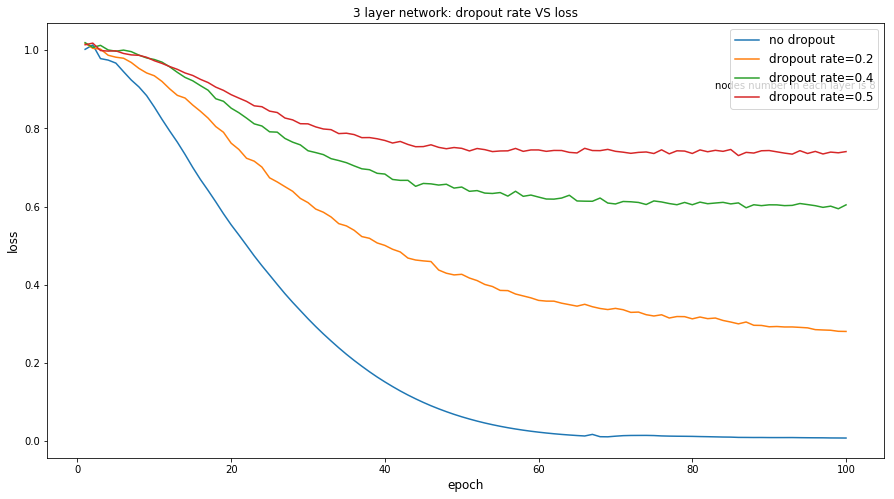

In [25]:
fig,ax = plt.subplots(figsize=(15,8))

ax.plot(range(1,101),loss_train7,label = 'no dropout')
ax.plot(range(1,101),loss_train5,label = 'dropout rate=0.2')
ax.plot(range(1,101),loss_train6,label = 'dropout rate=0.4')
ax.plot(range(1,101),loss_train,label = 'dropout rate=0.5')

ax.set_xlabel('epoch',fontsize='large')
ax.set_ylabel('loss',fontsize='large')
ax.legend(fontsize='large')
ax.set_title('3 layer network: dropout rate VS loss')
ax.text(83,0.9,'nodes number in each layer is 8')
fig.savefig('D:\\CS760\\pj\\3layer_2.jpg')

In [26]:
model8 = ThreeLayerNet2(train_x.shape[1], 32, 32)
optimizer = torch.optim.Adam(model8.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train8=[]

for i in range(100):
    print(i,' ', end='')
    loss_train8.append(train(model8,train_x,train_y,criterion,optimizer))
    
model8_loss = valid(model8, valid_x, valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


1.0003201961517334
1  1.035933256149292
2  0.9991469383239746
3  1.0044641494750977
4  1.0113627910614014
5  0.9990820288658142
6  0.9833683371543884
7  0.9753221869468689
8  0.9727731943130493
9  0.9655455350875854
10  0.9482880234718323
11  0.9254399538040161
12  0.9036830067634583
13  0.8829984664916992
14  0.8588600754737854
15  0.8302327990531921
16  0.8000513911247253
17  0.7725867033004761
18  0.7454190254211426
19  0.7167017459869385
20  0.6861064434051514
21  0.6574403643608093
22  0.6288196444511414
23  0.5987352132797241
24  0.5692514777183533
25  0.5406318306922913
26  0.512514591217041
27  0.48467084765434265
28  0.45714396238327026
29  0.43003883957862854
30  0.4034888744354248
31  0.37748605012893677
32  0.352079302072525
33  0.32736578583717346
34  0.3034385144710541
35  0.2802588641643524
36  0.257965624332428
37  0.23664946854114532
38  0.21631242334842682
39  0.1969945728778839
40  0.17876538634300232
41  0.16159680485725403
42  0.14550437033176422
43  0.130500227212

In [27]:
print('Model 1: 3 layer network with 8 nodes in each hidden layer, drop out rate = 0.5, validation MSE LOSS = ', model1_loss)
print('Model 2: 3 layer network with 4 nodes in each hidden layer, drop out rate = 0.5, validation MSE LOSS = ', model2_loss)
print('Model 3: 3 layer network with 16 nodes in each hidden layer, drop out rate = 0.5, validation MSE LOSS = ', model3_loss)
print('Model 4: 3 layer network with 32 nodes in each hidden layer, drop out rate = 0.5, validation MSE LOSS = ', model4_loss)
print('Model 5: 3 layer network with 8 nodes in each hidden layer, drop out rate = 0.2, validation MSE LOSS = ', model5_loss)
print('Model 6: 3 layer network with 8 nodes in each hidden layer, drop out rate = 0.4, validation MSE LOSS = ', model6_loss)
print('Model 7: 3 layer network with 8 nodes in each hidden layer, drop out rate = 0, validation MSE LOSS = ', model7_loss)
print('Model 8: 3 layer network with 32 nodes in each hidden layer, drop out rate = 0, validation MSE LOSS = ', model8_loss)

Model 1: 3 layer network with 8 nodes in each hidden layer, drop out rate = 0.5, validation MSE LOSS =  0.3301808834075928
Model 2: 3 layer network with 4 nodes in each hidden layer, drop out rate = 0.5, validation MSE LOSS =  1.025820255279541
Model 3: 3 layer network with 16 nodes in each hidden layer, drop out rate = 0.5, validation MSE LOSS =  1.025818943977356
Model 4: 3 layer network with 32 nodes in each hidden layer, drop out rate = 0.5, validation MSE LOSS =  0.04846538230776787
Model 5: 3 layer network with 8 nodes in each hidden layer, drop out rate = 0.2, validation MSE LOSS =  0.06378389149904251
Model 6: 3 layer network with 8 nodes in each hidden layer, drop out rate = 0.4, validation MSE LOSS =  0.18122771382331848
Model 7: 3 layer network with 8 nodes in each hidden layer, drop out rate = 0, validation MSE LOSS =  0.00919942557811737
Model 8: 3 layer network with 32 nodes in each hidden layer, drop out rate = 0, validation MSE LOSS =  0.006566750817000866


In [28]:
bestmodel_loss = valid(model8, test_x, test_y,criterion)
model8.eval()
bestmodel_pred = model8(test_x)
print(bestmodel_loss)
print(bestmodel_pred)

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


0.41175171732902527
tensor([[-0.1041],
        [-0.1041],
        [-0.1041],
        ...,
        [-0.1042],
        [-0.1040],
        [-0.1042]], grad_fn=<AddmmBackward>)


In [29]:
def restore(pred_y,trainset):
    standard =trainset[['totals_transactionRevenue']].values
    standard = np.log(standard+1)
    mean=np.mean(standard,axis=0)
    mean = mean[0]

    stdev=np.std(standard,axis=0,ddof=1)
    stdev = stdev[0]

    y = pred_y*stdev + mean
    y=y.detach().numpy()
    pred_revenue = np.exp(y)-1
    pred_revenue = np.where(pred_revenue<0.01,0,pred_revenue)
    return y, pred_revenue

In [30]:
r1,r2 = restore(bestmodel_pred,trainset)

In [31]:
test_ID['pred_revenue']=r2
test_ID['true_revenue']=testset['totals_transactionRevenue']
test_ID

,fullVisitorId,pred_revenue,true_revenue
0,7460955084541987166,0.0,0.0
1,460252456180441002,0.0,0.0
2,3461808543879602873,0.0,0.0
3,975129477712150630,0.0,0.0
4,8381672768065729990,0.0,0.0
5,2866297766347322467,0.0,0.0
6,2235365487897339889,0.0,0.0
7,1303090465617023038,0.0,0.0
8,0459669224143241747,0.0,0.0
9,589440789980446309,0.0,0.0


In [32]:
test_ID

,fullVisitorId,pred_revenue,true_revenue
0,7460955084541987166,0.0,0.0
1,460252456180441002,0.0,0.0
2,3461808543879602873,0.0,0.0
3,975129477712150630,0.0,0.0
4,8381672768065729990,0.0,0.0
5,2866297766347322467,0.0,0.0
6,2235365487897339889,0.0,0.0
7,1303090465617023038,0.0,0.0
8,0459669224143241747,0.0,0.0
9,589440789980446309,0.0,0.0


In [33]:
outcome = test_ID.groupby(['fullVisitorId']).sum()
outcome['pred_revenue']=np.log(outcome['pred_revenue']+1)
outcome['true_revenue']=np.log(outcome['true_revenue']+1)
outcome

,pred_revenue,true_revenue
fullVisitorId,,
0000018966949534117,0.00000,0.0
0000039738481224681,0.00000,0.0
0000073585230191399,0.00000,0.0
0000087588448856385,0.00000,0.0
0000149787903119437,0.00000,0.0
0000196310838896290,0.00000,0.0
00001995526696366,0.00000,0.0
0000255704530917106,0.00000,0.0
0000268499301061358,0.00000,0.0


In [38]:
outcome['loss']=(outcome['true_revenue']-outcome['pred_revenue'])**2
RMSE = math.sqrt((outcome['loss'].sum())/len(outcome))
RMSE

1.352332764791406

In [35]:
outcome[outcome['true_revenue']>0]

,pred_revenue,true_revenue,loss
fullVisitorId,,,
0002290239070540853,17.976233,17.881456,0.004491
0004938716430839957,17.976233,20.348354,2.813481
000851668596082488,17.976233,17.186592,0.311766
0008537705738701172,17.976233,18.236518,0.033874
0009698479874990121,17.976233,17.280621,0.241937
0010364132187346780,19.362526,20.982085,1.311486
00135135903467220901,18.669380,18.310643,0.064346
0013609645960719482,17.976233,18.022886,0.001088
0014589329325528540,17.976233,14.144815,7.339880
